<a href="https://colab.research.google.com/github/erikaminarikova/REFRESH/blob/main/Example_10_ordinal_sums_loan_data_2classes_different_learning_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 7.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pygad
import numpy as np
import pandas as pd
import statistics
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import image
import seaborn as sns

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
import time

In [6]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, mean_squared_error

In [7]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#ordina sums functions

# defining the generic functions for individual classes
def yes_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
    return 1-max(0.0, (((1-x) ** kappa) + ((1-y) ** kappa) - ((1-a) ** kappa))) ** (1 / kappa)

def no_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
        return max(0.0, ((x ** lam) + (y ** lam) - (a ** lam))) ** (1 / lam)

def maybe_function(x: float, y: float, a:float, kappa: float, lam: float, gamma: float = 1) -> float:
    if gamma == 0:
            # r = 0 means we use the geometric mean
        return 0
    elif gamma < 0:
            # r < 0 means we handle cases where x or y are 0
        if x == 0 or y == 0:
            return 0
        else:
                value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    else:
            value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    return statistics.median([0, 1, value])

# defining function for classification: deviding values according thir value to which fuction we use
def classification(x: float, y: float, a: float, kappa: float, lam: float, gamma: float) -> float:
    if x<a and y<a:
        value = no_function(x,y,a,1,lam,1)
    elif x>a and y>a:
        value = yes_function(x,y,a,kappa,1,1)
    else:
        value = maybe_function(x,y,a,1,1,gamma)
    return round(value,4)

In [ ]:
#alg for learning parameters in ordinal sums functions
def calculate_param_using_gen_alg(data:[] = []):
    #preparing input-output data
    df = data
    columns=len(df.columns)

    def fitness_func(ga_instance, solution, solution_idx):
        param = np.array(solution)
        df['value']=df.apply(lambda row: abs(row[0]-param[4]), axis =1)
        # parameters for attributes
        i=5
        j=0
        while j < columns-2:
            df['value']=df.apply(lambda row: classification(row['value'], abs(row[j+1]-param[i]), param[0], param[1], param[2], param[3]),
                                                            axis = 1)
            i += 1
            j += 1
        df['error']=df.apply(lambda row: math.exp2(np.abs(row['value'] - row['target']))/len(df), axis=1)
        fitness1 = 1/math.sqrt(sum(df['error']))
        df['calc_value_class'] = df.apply(lambda row: 0 if (row['value']<0.5) else 1, axis=1)
        df['target'] = df.apply(lambda row: 0 if (row['target']<0.5) else 1, axis=1)
        fitness2 = accuracy_score(df[['calc_value_class']].values, df[['target']].values)
        fitness = fitness1 + fitness2
        return fitness

    fitness_function = fitness_func

    num_generations = 60
    num_parents_mating = 12

    sol_per_pop = 24
    num_genes = 12 #number of learnt (tuned) parameters

    init_range_low = 0
    init_range_high = 1

    parent_selection_type = "sss"
    keep_parents = 2

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 15

    ga_instance = pygad.GA(num_generations=num_generations,
                            num_parents_mating=num_parents_mating,
                            fitness_func=fitness_function,
                            sol_per_pop=sol_per_pop,
                            num_genes=num_genes,
                            init_range_low=init_range_low,
                            init_range_high=init_range_high,
                            parent_selection_type=parent_selection_type,
                            keep_parents=keep_parents,
                            crossover_type=crossover_type,
                            mutation_type=mutation_type,
                            mutation_percent_genes=mutation_percent_genes,
                            gene_space=[{'low': 0, 'high': 1},{'low': 0, 'high': 3},
                                        {'low': 0, 'high': 3},{'low': 0, 'high': 1},
                                        [0,1], [0,1], [0,1], [0,1],
                                        [0,1], [0,1], [0,1], [0,1]])

    ga_instance.run()

    ga_instance.plot_fitness()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    #filename = 'genetic'
    #ga_instance.save(filename=filename)

    solution_param= np.array(solution)
    df['calc_value']=df.apply(lambda row: abs(row[0]-solution_param[4]), axis = 1)
    columns=len(df.columns)
    j=0
    i=5
    while j < columns-6:
        df['calc_value']=df.apply(lambda row: classification(row['calc_value'], abs(row[j+1] - solution_param[i]), solution_param[0], solution_param[1], solution_param[2], solution_param[3]),
                                                        axis = 1)
        i += 1
        j += 1

    merge_data = df
    # merge_data.to_csv("data/output.csv")
    mean_error = (sum(merge_data['error'])) / len(merge_data)
    kappa_result = solution_param[1]
    lam_result = solution_param[2]
    gamma_result = solution_param[3]
    a_result = solution_param[0]
    return merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, solution_param, solution_fitness, solution_idx



In [19]:
# Optimized and safe version
import numpy as np
import math
import pygad
import statistics
import pandas as pd
from sklearn.metrics import f1_score

# ---- Ordinal Sums Functions ---- #
def yes_function(x, y, a, kappa, lam, gamma=1):
    return 1 - np.maximum(0.0, ((1-x)**kappa + (1-y)**kappa - (1-a)**kappa))**(1/kappa)

def no_function(x, y, a, kappa, lam, gamma=1):
    return np.maximum(0.0, (x**lam + y**lam - a**lam))**(1/lam)

def maybe_function(x, y, a, kappa, lam, gamma=1):
    if x is None or y is None:
        return 0
    if gamma == 0:
        return 0
    else:
        value = gamma*(1/a)*x*y + (1-gamma)*(1 - (1/(1-a))*(1-x)*(1-y))
    return statistics.median([0, 1, value])

def classification(x, y, a, kappa, lam, gamma):
    if x < a and y < a:
        return no_function(x, y, a, 1, lam, 1)
    elif x > a and y > a:
        return yes_function(x, y, a, kappa, 1, 1)
    else:
        return maybe_function(x, y, a, 1, 1, gamma)

# ---- Vectorized wrapper ---- #
def classification_vec(values, diffs, a, kappa, lam, gamma):
    if values.size == 0 or diffs.size == 0:
        return np.zeros_like(values)

    results = np.zeros_like(values)
    mask_no = (values < a) & (diffs < a)
    mask_yes = (values > a) & (diffs > a)
    mask_maybe = ~(mask_no | mask_yes)

    if np.any(mask_no):
        results[mask_no] = no_function(values[mask_no], diffs[mask_no], a, 1, lam, 1)
    if np.any(mask_yes):
        results[mask_yes] = yes_function(values[mask_yes], diffs[mask_yes], a, kappa, 1, 1)
    if np.any(mask_maybe):
        for idx in np.where(mask_maybe)[0]:
            results[idx] = maybe_function(values[idx], diffs[idx], a, 1, 1, gamma)

    return np.round(results, 4)

# ---- Genetic Algorithm ---- #
def calculate_param_using_gen_alg(data: pd.DataFrame):
    df = data.copy()
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()
    n_features = X.shape[1]

    def fitness_func(ga_instance, solution, solution_idx):
        try:
            param = np.array(solution, dtype=float)
            value = np.abs(X[:, 0] - param[5])
            i = 6
            for j in range(n_features-1):
                diff = np.abs(X[:, j] - param[i])
                value = classification_vec(value, diff,
                                           param[0], param[1], param[2], param[3])
                i += 1

            error = np.exp2(np.abs(value - y))
            fitness1 = 1.0 / (math.sqrt(np.mean(error)) + 1e-8)  # avoid division by zero

            calc_class = (value >= param[0]).astype(int)
            target_class = (y >= param[0]).astype(int)
            fitness2 = f1_score(target_class, calc_class)

            if np.isnan(fitness1) or np.isnan(fitness2):
                return 0

            return param[4]*fitness1 + (1-param[4])*fitness2

        except Exception as e:
            print(f"Fitness calculation failed: {e}")
            return 0

    ga_instance = pygad.GA(
        num_generations=60,
        num_parents_mating=12,
        fitness_func=fitness_func,
        sol_per_pop=24,
        num_genes=16,
        init_range_low=0,
        init_range_high=1,
        parent_selection_type="tournament",
        K_tournament=3,
        keep_parents=2,
        crossover_type="single_point",
        mutation_type="random",
        mutation_percent_genes=15,
        gene_space=[
            {'low': 0.3, 'high': 0.7},   # a
            {'low': 0, 'high': 3},       # kappa
            {'low': 0, 'high': 3},       # lambda
            {'low': 0, 'high': 1},       # gamma
            {'low': 0, 'high': 1},       # fitness weight
            *([[0,1]] * 11)               # binary params
        ]
    )

    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    best_params = np.array(solution, dtype=float)
    value = np.abs(X[:, 0] - best_params[5])
    i = 6
    for j in range(n_features-1):
        diff = np.abs(X[:, j] - best_params[i])
        value = classification_vec(value, diff,
                                   best_params[0], best_params[1], best_params[2], best_params[3])
        i += 1

    error = np.exp2(np.abs(value - y))
    calc_class = (value >= best_params[0]).astype(int)
    target_class = (y >= best_params[0]).astype(int)

    df["calc_value"] = value
    df["error"] = error
    df["calc_value_class"] = calc_class
    df["target_class"] = target_class

    mean_error = np.mean(error)

    return (
        df,                # dataset with calc values
        mean_error,
        best_params[1],    # kappa
        best_params[2],    # lambda
        best_params[3],    # gamma
        best_params[0],    # a
        best_params,       # full parameter vector
        solution_fitness,
        solution_idx
    )


In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Fuction to despay relevant results
def show_results(data, mean_error, gamma_result, lam_result, kappa_result, a_result):
    # calculate the mean squared error
    target_values = data[['target']].values
    value = data[['calc_value']].values
    MSE = mean_squared_error(target_values, value)
    RMSE = math.sqrt(MSE)
    # print the results
    print('Results:')
    if all(col in data.columns for col in ['value','error']):
      print(data.drop(columns=['value','error']))
    else:
      print(data)
    #print('mean error: ', mean_error)
    print('\u03B3 = ', round(gamma_result, 4))
    print('\u03BB = ', round(lam_result, 4))
    print('\u03BA = ', round(kappa_result, 4))
    print('a = ', round(a_result, 4))
    print('Mean squared error = ', round(MSE, 4))
    print('Root Mean Square Error = ', round(RMSE, 4))

In [11]:
def print_attr_coef(sol_param):
  coeficients = []
  for i in sol_param:
    if i == 1:
      pom = '1-decreasing'
      coeficients.append(pom)
    elif i == 0:
      pom = '0-increasing'
      coeficients.append(pom)

  name_columns = data.drop(columns=['target']).columns

  merge_list = name_columns + [': '] + coeficients
  for list in merge_list:
    print(list)

In [12]:
def view_chart(a, kappa, lam):
    """ if df:
        variables_for_plot = st.multiselect('Select 2 dependent variables for plot:', df.columns, max_selections=2)
        if variables_for_plot:
            df_for_plot = df[variables_for_plot]
            x=df_for_plot.iloc[:, 0]
            y=df_for_plot.iloc[:, 1]
            plt.scatter(x,y) """
    plt.figure(figsize=(3, 3))
    plt.subplot(111)
    y = np.arange(0, 1, 0.05)
    x = [a] * len(y)
    plt.scatter(x, y, c = 'black', s = 1)

    x = np.arange(0, 1, 0.05)
    y = [a] * len(x)
    plt.scatter(x, y, c = 'black', s = 1)

    y1 = np.arange(a, 1.0, 0.001)
    b=1
    x1 = 1-((1-a)**kappa-(1-y1)**kappa)**(1/kappa)
    plt.plot(x1, y1, c = 'red')
    plt.fill_between(y1,x1, b, color='red')

    y2 = np.arange(0, a, 0.01)
    x2 = ((a**lam)-(y2**lam))**(1/lam)
    plt.plot(y2, x2, c = 'green')
    plt.fill_between(y2,x2,color='green')

    # y3 = np.arange(a, 1.01, 0.01)
    # x3 = 1-(((1-a)**kappa)-((1-y3)**kappa))**(1/kappa)
    # z = np.min(b, x2)
    # plt.fill_between(y3,x3,y2=0, color='blue')

    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.annotate('D', xy=(a, a), xytext=(a + 0.2, a + 0.2), fontsize=12)
    plt.annotate('C', xy=(a, a), xytext=(a - 0.3, a - 0.3), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a - 0.3, a + 0.2), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a + 0.2, a - 0.3), fontsize=12)

    plt.annotate('a', xy=(a, a), xytext=(a - 0.04, a - 0.63), fontsize=12)
    plt.annotate('a', xy=(a, a), xytext=(a - 0.63, a - 0.04), fontsize=12)

    return (plt)

In [37]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/loan_data_train.csv', sep=',')

In [16]:
data.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,target
count,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.00000,491.000000
mean,0.193964,0.634728,0.248739,0.778004,0.143343,0.066205,0.040235,0.202094,0.701551,0.844578,0.51833,0.696538
std,0.391085,0.481516,0.334350,0.416012,0.342225,0.073382,0.076263,0.124857,0.142896,0.347397,0.39080,0.460222
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011577,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.034242,0.000000,0.135311,0.743590,1.000000,0.00000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.000000,0.046382,0.027024,0.175109,0.743590,1.000000,0.50000,1.000000
75%,0.000000,1.000000,0.333333,1.000000,0.000000,0.071589,0.055992,0.225760,0.743590,1.000000,1.00000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


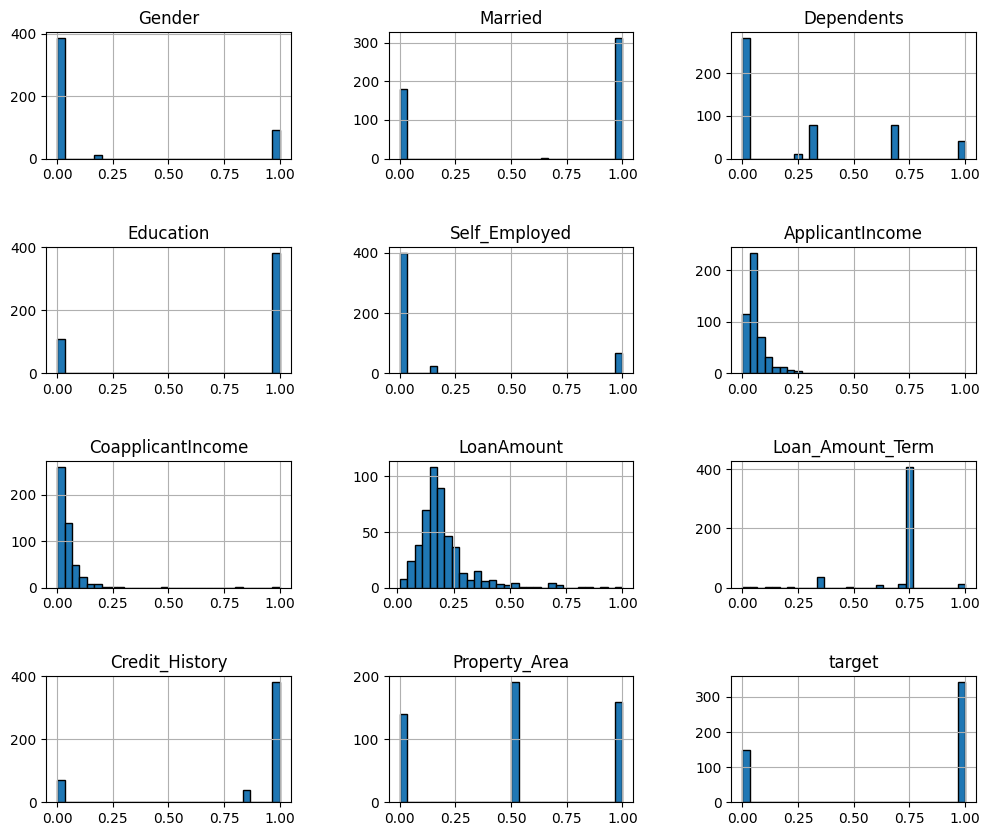

In [17]:
# Grafical representation of distribution of attributes
data.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [34]:
df_train = df_test
df_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,target
0,0.0,1.0,0.000000,1,0.000000,0.110489,0.000000,0.316932,0.743590,1.000000,0.5,1
1,0.0,1.0,0.000000,1,0.000000,0.051453,0.000000,0.175109,0.743590,0.842199,0.5,1
2,0.0,1.0,0.666667,1,0.000000,0.049685,0.034728,0.215630,0.743590,1.000000,0.0,1
3,1.0,0.0,0.000000,1,0.000000,0.034014,0.000000,0.089725,0.743590,1.000000,0.0,1
4,0.0,0.0,0.000000,1,0.000000,0.031763,0.000000,0.088278,0.743590,1.000000,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.0,1.0,0.000000,1,0.140893,0.044106,0.000000,0.047757,0.358974,1.000000,0.0,1
119,1.0,0.0,0.000000,1,0.000000,0.029153,0.000000,0.068017,0.743590,1.000000,0.0,1
120,0.0,1.0,0.333333,1,0.000000,0.033791,0.044232,0.164978,1.000000,1.000000,0.5,1
121,0.0,1.0,0.666667,1,0.140893,0.029066,0.044160,0.144718,0.743590,1.000000,1.0,1


In [35]:
start_time = time.time()
merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, sol_param, solution_fitness, solution_idx = calculate_param_using_gen_alg(df_train)

show_results(merge_data, mean_error, gamma_result, lam_result, kappa_result, a_result)
print_attr_coef(sol_param)
print("wages: {w1}, {w2}".format(w1=sol_param[4], w2=1-sol_param[4]))
print("Parameters of the best solution : {solution_idx}".format(solution_idx=solution_idx))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

print('time:', (time.time()-start_time)/60)

Results:
     Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0       0.0      1.0    0.000000          1       0.000000         0.110489   
1       0.0      1.0    0.000000          1       0.000000         0.051453   
2       0.0      1.0    0.666667          1       0.000000         0.049685   
3       1.0      0.0    0.000000          1       0.000000         0.034014   
4       0.0      0.0    0.000000          1       0.000000         0.031763   
..      ...      ...         ...        ...            ...              ...   
118     0.0      1.0    0.000000          1       0.140893         0.044106   
119     1.0      0.0    0.000000          1       0.000000         0.029153   
120     0.0      1.0    0.333333          1       0.000000         0.033791   
121     0.0      1.0    0.666667          1       0.140893         0.029066   
122     0.0      1.0    0.000000          1       0.140893         0.781534   

     CoapplicantIncome  LoanAmount  Loan_A

In [21]:
def calculate_tests(target_values, value):
  print('Accuracy score = ', accuracy_score(target_values, value))
  print('F1 = ', f1_score(target_values, value, average= 'macro'))
  print('Precision = ', precision_score(target_values, value, average= 'macro'))
  print('Recall = ', recall_score(target_values, value, average= 'macro'))
  #confusion matrix
  confusion_matrix = metrics.confusion_matrix(target_values, value)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
  cm_display.plot()
  plt.show()

Accuracy score =  0.8130081300813008
F1 =  0.7595410114747132
Precision =  0.7379360465116279
Recall =  0.8683618361836184


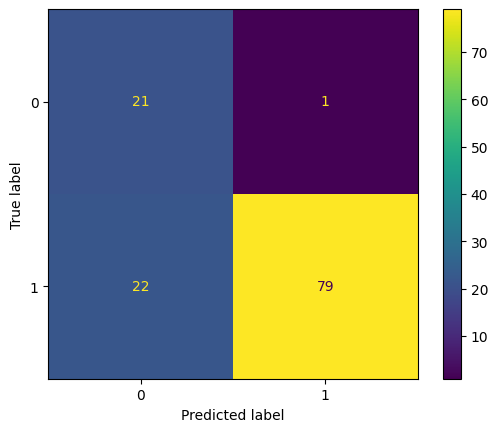

In [36]:
# tests for train dataset: testing_df
calculate_tests(merge_data[["calc_value_class"]].values, merge_data[['target_class']].values)

<ipython-input-5-6737d8efe725>:21: RuntimeWarning: invalid value encountered in power
  x1 = 1-((1-a)**kappa-(1-y1)**kappa)**(1/kappa)


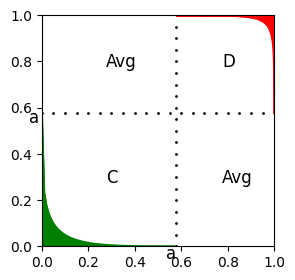

In [ ]:
# df = pd.DataFrame()
# chart = view_chart(df, 0.2305, 0.8658, 3.7278, 0.9559)
# chart = view_chart(0.5,1,1)

chart = view_chart(0.576, 0.1413*2, 0.1663*2)
chart.show()

In [33]:
#to know -2 or -5 in loop - remove additional columns
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/loan_data_test.csv', sep=',')
df_test,00

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,target
0,0.0,1.0,0.000000,1,0.000000,0.110489,0.000000,0.316932,0.743590,1.000000,0.5,1
1,0.0,1.0,0.000000,1,0.000000,0.051453,0.000000,0.175109,0.743590,0.842199,0.5,1
2,0.0,1.0,0.666667,1,0.000000,0.049685,0.034728,0.215630,0.743590,1.000000,0.0,1
3,1.0,0.0,0.000000,1,0.000000,0.034014,0.000000,0.089725,0.743590,1.000000,0.0,1
4,0.0,0.0,0.000000,1,0.000000,0.031763,0.000000,0.088278,0.743590,1.000000,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.0,1.0,0.000000,1,0.140893,0.044106,0.000000,0.047757,0.358974,1.000000,0.0,1
119,1.0,0.0,0.000000,1,0.000000,0.029153,0.000000,0.068017,0.743590,1.000000,0.0,1
120,0.0,1.0,0.333333,1,0.000000,0.033791,0.044232,0.164978,1.000000,1.000000,0.5,1
121,0.0,1.0,0.666667,1,0.140893,0.029066,0.044160,0.144718,0.743590,1.000000,1.0,1


In [24]:
# Calculate ordinal sums on test dataset
columns=len(df_test.columns)
df_test['calc_value']=df_test.apply(lambda row: abs(sol_param[5]-row[0]), axis =1)
# parameters for attributes
i=6
j=0
while j < columns-2:
  df_test['calc_value']=df_test.apply(lambda row: classification(row['calc_value'], abs(row[j+1]-sol_param[i]), sol_param[0], sol_param[1], sol_param[2], sol_param[3]), axis = 1)
  print(sol_param[i])
  i += 1
  j += 1
show_results(df_test, 0, 0, 0, 0, 0)

0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
Results:
     Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0       0.0      1.0    0.000000          1       0.000000         0.110489   
1       0.0      1.0    0.000000          1       0.000000         0.051453   
2       0.0      1.0    0.666667          1       0.000000         0.049685   
3       1.0      0.0    0.000000          1       0.000000         0.034014   
4       0.0      0.0    0.000000          1       0.000000         0.031763   
..      ...      ...         ...        ...            ...              ...   
118     0.0      1.0    0.000000          1       0.140893         0.044106   
119     1.0      0.0    0.000000          1       0.000000         0.029153   
120     0.0      1.0    0.333333          1       0.000000         0.033791   
121     0.0      1.0    0.666667          1       0.140893         0.029066   
122     0.0      1.0    0.000000          1       0.140893         0.781534   

  

In [ ]:
print(classification(0.9625702184044478  ,1, sol_param[0], sol_param[1], sol_param[2], sol_param[3]))

1.0


In [ ]:
def calculate_tests(target_values, value):
  print('Accuracy score = ', accuracy_score(target_values, value))
  print('F1 = ', f1_score(target_values, value, average= 'macro'))
  print('Precision = ', precision_score(target_values, value, average= 'macro'))
  print('Recall = ', recall_score(target_values, value, average= 'macro'))
  #confusion matrix
  confusion_matrix = metrics.confusion_matrix(target_values, value)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
  cm_display.plot()
  plt.show()

In [28]:
df_test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,target,calc_value,calc_value_class
0,0.0,1.0,0.000000,1,0.000000,0.110489,0.000000,0.316932,0.743590,1.000000,0.5,1,0.057600,0
1,0.0,1.0,0.000000,1,0.000000,0.051453,0.000000,0.175109,0.743590,0.842199,0.5,1,0.057600,0
2,0.0,1.0,0.666667,1,0.000000,0.049685,0.034728,0.215630,0.743590,1.000000,0.0,1,0.000000,0
3,1.0,0.0,0.000000,1,0.000000,0.034014,0.000000,0.089725,0.743590,1.000000,0.0,1,0.000000,0
4,0.0,0.0,0.000000,1,0.000000,0.031763,0.000000,0.088278,0.743590,1.000000,0.5,1,0.057600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.0,1.0,0.000000,1,0.140893,0.044106,0.000000,0.047757,0.358974,1.000000,0.0,1,0.000000,0
119,1.0,0.0,0.000000,1,0.000000,0.029153,0.000000,0.068017,0.743590,1.000000,0.0,1,0.000000,0
120,0.0,1.0,0.333333,1,0.000000,0.033791,0.044232,0.164978,1.000000,1.000000,0.5,1,0.057600,0
121,0.0,1.0,0.666667,1,0.140893,0.029066,0.044160,0.144718,0.743590,1.000000,1.0,1,0.273905,0


In [31]:
df_test['calc_value_class'] = df_test.apply(lambda row: 0 if (row['calc_value']<a_result) else 1, axis=1)
print(a_result)
df_test

0.36685387919813506


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,target,calc_value,calc_value_class
0,0.0,1.0,0.000000,1,0.000000,0.110489,0.000000,0.316932,0.743590,1.000000,0.5,1,0.057600,0
1,0.0,1.0,0.000000,1,0.000000,0.051453,0.000000,0.175109,0.743590,0.842199,0.5,1,0.057600,0
2,0.0,1.0,0.666667,1,0.000000,0.049685,0.034728,0.215630,0.743590,1.000000,0.0,1,0.000000,0
3,1.0,0.0,0.000000,1,0.000000,0.034014,0.000000,0.089725,0.743590,1.000000,0.0,1,0.000000,0
4,0.0,0.0,0.000000,1,0.000000,0.031763,0.000000,0.088278,0.743590,1.000000,0.5,1,0.057600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.0,1.0,0.000000,1,0.140893,0.044106,0.000000,0.047757,0.358974,1.000000,0.0,1,0.000000,0
119,1.0,0.0,0.000000,1,0.000000,0.029153,0.000000,0.068017,0.743590,1.000000,0.0,1,0.000000,0
120,0.0,1.0,0.333333,1,0.000000,0.033791,0.044232,0.164978,1.000000,1.000000,0.5,1,0.057600,0
121,0.0,1.0,0.666667,1,0.140893,0.029066,0.044160,0.144718,0.743590,1.000000,1.0,1,0.273905,0


In [26]:
#prepare test data for tests
target_values = df_test[['target']].values
value = df_test[['calc_value_class']].values

Accuracy score =  0.2764227642276423
F1 =  0.23065570314147166
Precision =  0.22237762237762237
Recall =  0.38459302325581396


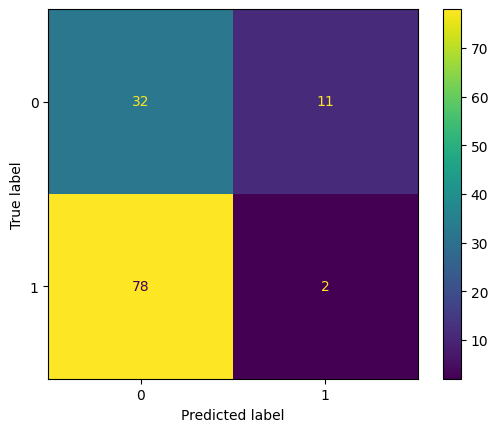

In [27]:
# tests for test dataset:
calculate_tests(target_values, value)

In [ ]:
merge_data.to_csv('/content/drive/MyDrive/Colab Notebooks/os_final_output.csv')

In [ ]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/os_final_output_test.csv')